In [20]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))
sys.path.insert(0, os.path.abspath('../../../'))
sys.path.insert(0, os.path.abspath('../../../../'))

In [21]:
import qiskit
provider = qiskit.IBMQ.load_account()
provider = qiskit.IBMQ.get_provider(hub='ibm-q-unibw', group='reservations', project='reservations')

ibmqfactory.load_account:WARNING:2021-10-26 19:11:25,747: Credentials are already in use. The existing account in the session will be replaced.


In [22]:
import numpy as np

from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import QAOA
from shared.QiskitMaxcut import *
from qiskit.algorithms.optimizers import COBYLA
from shared.graph_helper import generate_butterfly_graph
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from matplotlib import pyplot as plt
%matplotlib inline

graph_05_06_02_w


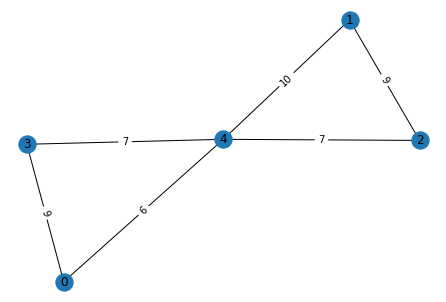

In [23]:
graph = generate_butterfly_graph(with_weights=True)
max_cut = Maxcut(graph)
max_cut_qubo = max_cut.to_qubo()
print(graph.name)
max_cut.draw()

In [24]:
step_size = 0.1
a_gamma = np.arange(0, np.pi, step_size)
b_beta = np.arange(0, np.pi, step_size)

In [25]:
a_gamma, b_beta = np.meshgrid(a_gamma, b_beta)
len(a_gamma)

32

In [26]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i,j,w in graph.edges.data('weight'):
        if x[i] != x[j]:
            obj -= w
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

In [27]:
from qiskit.algorithms.optimizers import COBYLA
quantum_instance = QuantumInstance(
                    backend=provider.get_backend('ibmq_toronto'),
                    measurement_error_mitigation_cls=CompleteMeasFitter,
                    measurement_error_mitigation_shots=1024,
                    shots=1024)

qaoa = QAOA(
            optimizer=COBYLA(maxiter=0),
            quantum_instance=quantum_instance,
            reps=1
            )

op, offset = max_cut_qubo.to_ising()

In [28]:
def create_cirucit(gamma,beta):
    circuits = qaoa.construct_circuit([gamma,beta], operator=op)
    circuit = circuits[0]
    circuit.measure_all()
    return circuit

In [ ]:
landscape = np.zeros(a_gamma.shape)

for i in range(0, len(landscape)):
    circuits = []
    for j in range(0, len(landscape)):
        # create circuits for entire row 
        circuit = create_cirucit(a_gamma[i][j], b_beta[i][j])
        circuits.append(circuit)
    
    # create one job with circuits 
    job_name = f"{graph.name}_spamem_row_{i}"
    job = quantum_instance.execute(circuits)
    #job.update_name(job_name)
    print(job_name)
    #print(job)
    
    # add results to landscape 
    k = 0
    for count in job.get_counts():
        mean = compute_expectation(count, graph)
        landscape[i,k % 32] = mean
        k += 1

In [ ]:
print(landscape)
plt.matshow(landscape)
plt.show()

In [ ]:
# Mean of landscape
np.mean(landscape)

In [ ]:
# Minimium 
np.min(landscape)

In [ ]:
# Display Coordinates of Minimum 
np.unravel_index(np.argmin(landscape), landscape.shape)

In [ ]:
# Gamma and beta value of Minimium
gamma, beta = np.unravel_index(np.argmin(landscape), landscape.shape)
opt_gamma = gamma * step_size
opt_beta = beta * step_size
print(f"Opt.Gamma: {opt_gamma}, Opt.Beta: {opt_beta}")

In [ ]:
# Save result matrix 
with open('landscape_creation_qc_butterfly_weighted_spamem_results_2.npy', 'wb') as f:
    np.save(f, landscape)

In [ ]:
import plotly.graph_objects as go

In [ ]:
# Plot landscape in 3D 
fig = go.Figure(data=go.Surface(z=landscape, x=a_gamma, y=b_beta))

fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor='limegreen', project_z=True))


fig.update_layout(title="QAOA with SPAMEM - MaxCut-Landscape", scene=dict(
    xaxis_title="γ",
    yaxis_title="β",
    zaxis_title="F(γ,β)"
))

In [ ]:
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import numpy as np
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import matplotlib.cm as cm

font_size = 14
fig, ax = plt.subplots(1,1, figsize=(5,5))

cmap = cm.get_cmap('viridis')
minv = np.min([landscape])
maxv = np.max([landscape])
normalizer=Normalize(minv,maxv)
im=cm.ScalarMappable(norm=normalizer)

plot = ax.contourf(a_gamma, b_beta, landscape, cmap = cmap, norm=normalizer)
ax.set_ylabel(r'$\beta$', fontsize = font_size)
ax.set_xlabel(r'$\gamma$', fontsize = font_size)
ax.set_title('IBMQ Toronto with SPAMEM', fontsize = font_size)

colorbar = plt.colorbar(im, ax=ax)
colorbar.ax.set_ylabel('Energies', fontsize = font_size)
plt.show()